# PDHG(TV正則化)

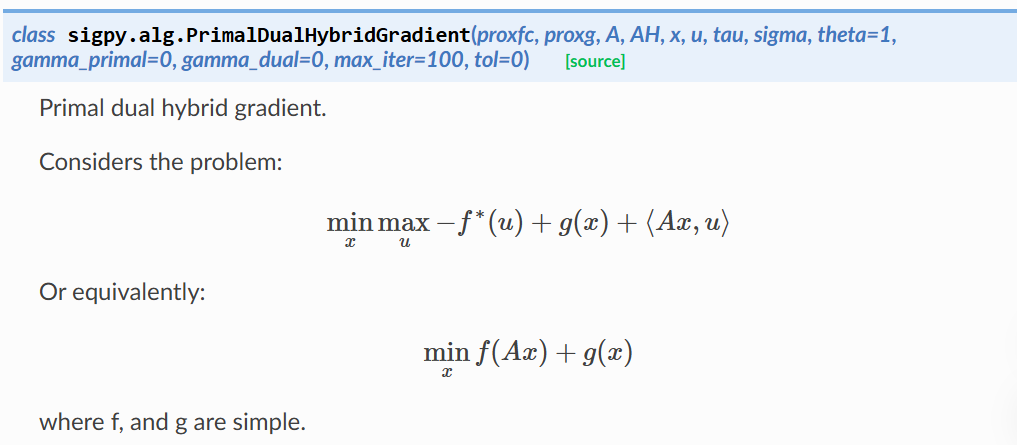

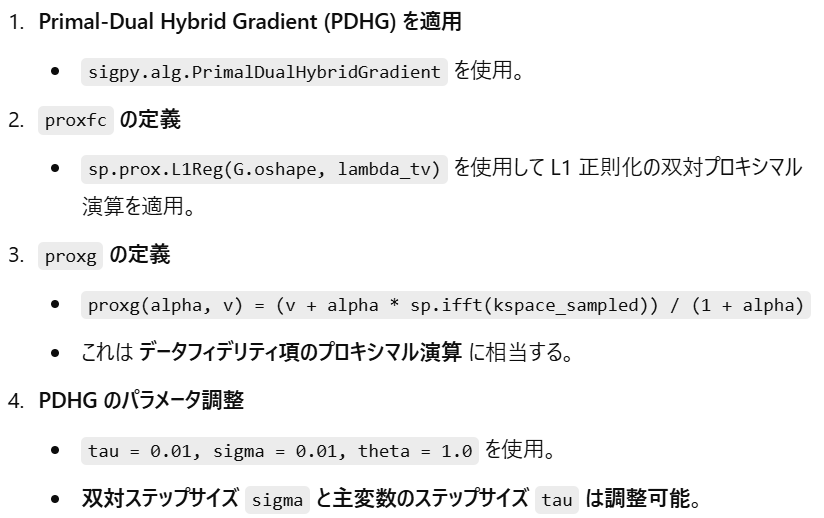

# proxg自作

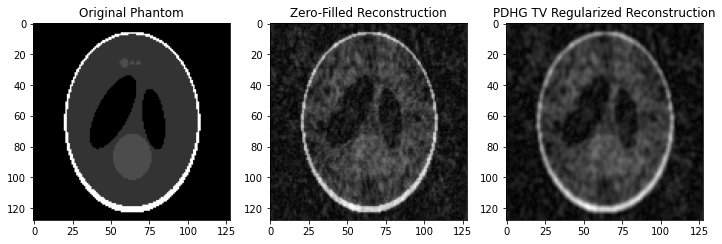

In [6]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)

# TV正則化の係数
lambda_tv = 0.01  # TV正則化の強さ

# Primal-Dual Hybrid Gradient のパラメータ
tau = 0.01  # 主変数のステップサイズ
sigma = 0.01  # 双対変数のステップサイズ
theta = 1.0  # 加速パラメータ

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# TV正則化オペレータ
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # x, y の差分を取る

# 初期化
x = np.copy(img_zero_filled)  # 初期画像
u = np.zeros(G.oshape, dtype=np.complex64)  # 初期双対変数

# **proxg (データフィデリティ項のプロキシマル演算)**
def proxg(alpha, v):
    """データフィデリティ項のプロキシマル演算"""
    return (v + alpha * sp.ifft(kspace_sampled)) / (1 + alpha)

# **proxfc (L1 正則化の双対プロキシマル演算)**
proxfc = sp.prox.L1Reg(G.oshape, lambda_tv)  # L1正則化

# PDHG による最適化
pdhg_solver = sp.alg.PrimalDualHybridGradient(
    proxfc=proxfc,
    proxg=proxg,
    A=G,
    AH=G.H,
    x=x,
    u=u,
    tau=tau,
    sigma=sigma,
    theta=theta,
    max_iter=100
)

# 画像再構成
while not pdhg_solver.done():
    pdhg_solver.update()

# 結果を取得
reconstructed_img = np.abs(x)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("PDHG TV Regularized Reconstruction")
plt.show()


# proxgにCG適用

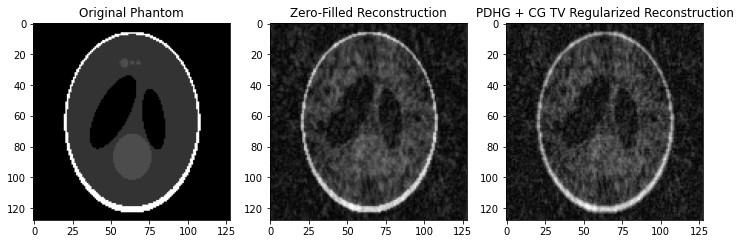

In [7]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)

# TV正則化の係数
lambda_tv = 0.01  # TV正則化の強さ

# Primal-Dual Hybrid Gradient のパラメータ
tau = 0.01  # 主変数のステップサイズ
sigma = 0.01  # 双対変数のステップサイズ
theta = 1.0  # 加速パラメータ

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# TV正則化オペレータ
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # x, y の差分を取る

# 初期化
x = np.copy(img_zero_filled)  # 初期画像
u = np.zeros(G.oshape, dtype=np.complex64)  # 初期双対変数

# **proxg (データフィデリティ項のプロキシマル演算を CG で解く)**
AHA = A.H * A + sp.linop.Identity(A.ishape)  # A^H A + I

def proxg(alpha, v):
    """データフィデリティ項のプロキシマル演算 (共役勾配法で解く)"""
    b = v + alpha * sp.ifft(kspace_sampled)  # 右辺
    cg_solver = sp.alg.ConjugateGradient(AHA, b, v, max_iter=10)  # 共役勾配法

    while not cg_solver.done():
        cg_solver.update()
    
    return v  # 更新された x を返す

# **proxfc (L1 正則化の双対プロキシマル演算)**
proxfc = sp.prox.L1Reg(G.oshape, lambda_tv)  # L1正則化

# PDHG による最適化
pdhg_solver = sp.alg.PrimalDualHybridGradient(
    proxfc=proxfc,
    proxg=proxg,
    A=G,
    AH=G.H,
    x=x,
    u=u,
    tau=tau,
    sigma=sigma,
    theta=theta,
    max_iter=100
)

# 画像再構成
while not pdhg_solver.done():
    pdhg_solver.update()

# 結果を取得
reconstructed_img = np.abs(x)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("PDHG + CG TV Regularized Reconstruction")
plt.show()


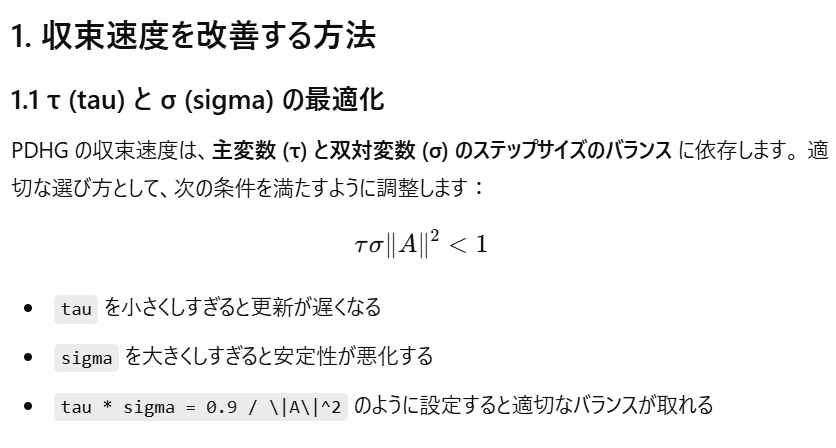

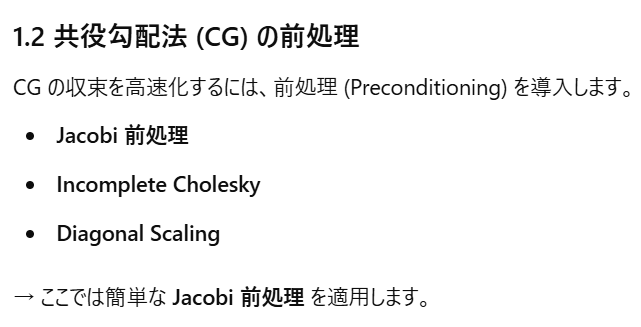

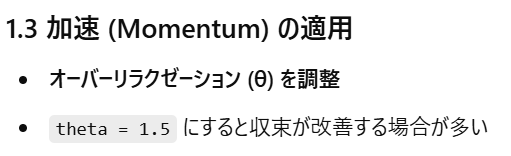

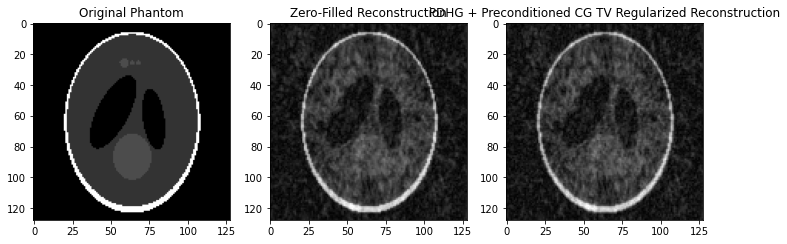

In [8]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)

# TV正則化の係数
lambda_tv = 0.01  # TV正則化の強さ

# Primal-Dual Hybrid Gradient のパラメータ
norm_A = np.linalg.norm(mask)  # Aのノルムを計算
tau = 0.9 / norm_A  # 主変数のステップサイズ
sigma = 0.9 / norm_A  # 双対変数のステップサイズ
theta = 1.5  # 加速パラメータ

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# TV正則化オペレータ
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # x, y の差分を取る

# 初期化
x = np.copy(img_zero_filled)  # 初期画像
u = np.zeros(G.oshape, dtype=np.complex64)  # 初期双対変数

# **Jacobi 前処理を用いた CG**
AHA = A.H * A + sp.linop.Identity(A.ishape)  # A^H A + I
diag_AHA = np.diag(AHA(np.ones(A.ishape)))  # Jacobi前処理

def jacobi_preconditioner(v):
    return v / diag_AHA  # Jacobi スケーリング

def proxg(alpha, v):
    """データフィデリティ項のプロキシマル演算 (共役勾配法 + Jacobi 前処理)"""
    b = v + alpha * sp.ifft(kspace_sampled)  # 右辺
    cg_solver = sp.alg.ConjugateGradient(AHA, b, v, P=jacobi_preconditioner, max_iter=20)  # Jacobi前処理付きCG

    while not cg_solver.done():
        cg_solver.update()
    
    return v  # 更新された x を返す

# **proxfc (L1 正則化の双対プロキシマル演算)**
proxfc = sp.prox.L1Reg(G.oshape, lambda_tv)  # L1正則化

# PDHG による最適化
pdhg_solver = sp.alg.PrimalDualHybridGradient(
    proxfc=proxfc,
    proxg=proxg,
    A=G,
    AH=G.H,
    x=x,
    u=u,
    tau=tau,
    sigma=sigma,
    theta=theta,
    max_iter=200
)

# 画像再構成
while not pdhg_solver.done():
    pdhg_solver.update()

# 結果を取得
reconstructed_img = np.abs(x)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("PDHG + Preconditioned CG TV Regularized Reconstruction")
plt.show()


あまり変わらない。。。